# Taller: Regresión Lineal Múltiple para House Prices

**Generado:** 2025-10-17 23:33:34 UTC

Este notebook realiza un flujo completo (EDA → limpieza → codificación → selección de variables → entrenar `LinearRegression` → evaluar → predecir) y guarda el archivo `predicciones.csv`. Está hecho para ejecutarse en el entorno donde están los archivos `train.csv` y `test.csv` (ya subidos a `/mnt/data`).

Se hicieron las visualizaciones de correlación usando `matplotlib` para compatibilidad con las reglas del entorno.

In [1]:

# Imports principales
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print('Imports cargados')


Imports cargados


In [13]:

# Cargar datos (ajusta rutas si es necesario)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Mostrar primeras filas
display(train.head(3))


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [14]:

# EDA básico
print('--- Info ---')
display(train.info())
print('\n--- Descripción numérica ---')
display(train.describe().T)
print('\nValores nulos más comunes:')
nulls = train.isnull().sum().sort_values(ascending=False)
display(nulls[nulls>0].head(20))


--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  


None


--- Descripción numérica ---


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0



Valores nulos más comunes:


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

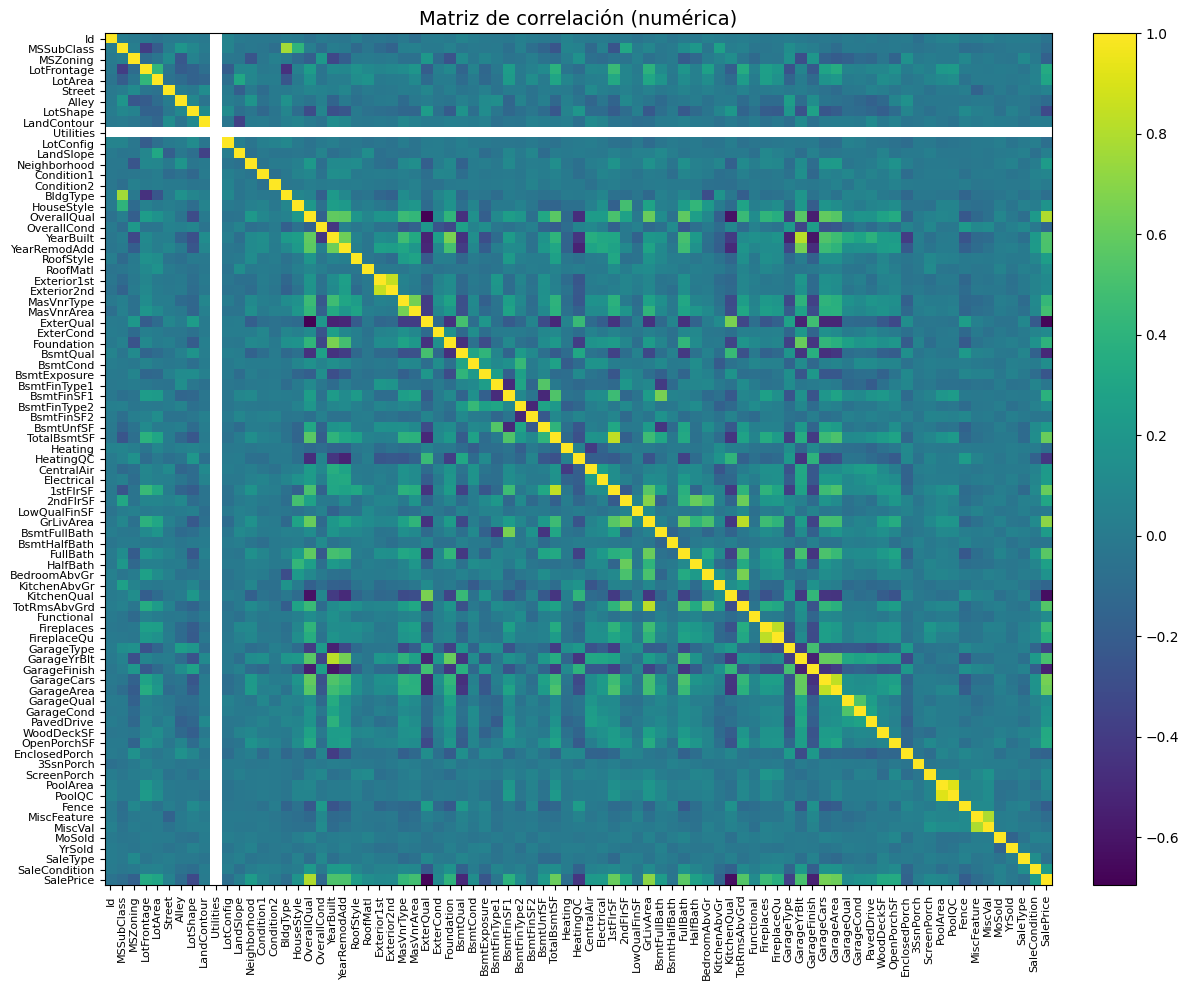

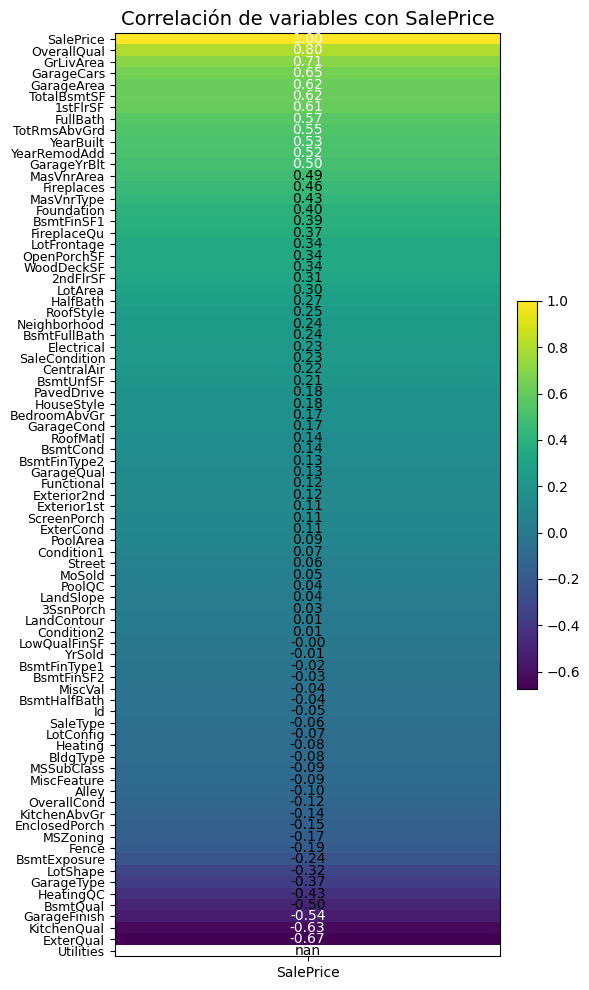

In [15]:

# Correlación: preparar dataframe numérico (codificar categóricas a códigos temporales para correlación con target)
df_corr = train.copy()

# Convertir object/categorical a codes
for col in df_corr.columns:
    if df_corr[col].dtype == 'object' or str(df_corr[col].dtype).startswith('category'):
        df_corr[col] = df_corr[col].astype('category').cat.codes

df_corr = df_corr.select_dtypes(include=[np.number]).copy()
df_corr.dropna(inplace=True)

corr = df_corr.corr()

# Heatmap: correlación completa (matplotlib)
plt.figure(figsize=(12,10))
im = plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Matriz de correlación (numérica)', fontsize=14)
# ticks
cols = corr.columns.tolist()
plt.xticks(range(len(cols)), cols, rotation=90, fontsize=8)
plt.yticks(range(len(cols)), cols, fontsize=8)
plt.tight_layout()
plt.show()

# Correlación solo con SalePrice - ordenadas
if 'SalePrice' in corr.columns:
    corr_target = corr[['SalePrice']].sort_values(by='SalePrice', ascending=False)
    plt.figure(figsize=(6,10))
    im = plt.imshow(corr_target, aspect='auto', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Correlación de variables con SalePrice', fontsize=14)
    plt.yticks(range(len(corr_target.index)), corr_target.index, fontsize=9)
    plt.xticks([0], ['SalePrice'])
    # Anotar valores
    for i, val in enumerate(corr_target['SalePrice']):
        plt.text(0, i, f"{val:.2f}", va='center', ha='center', color='white' if abs(val)>0.5 else 'black')
    plt.tight_layout()
    plt.show()
else:
    print('SalePrice no está en las columnas de correlación.')


In [9]:

# Limpieza y tratamiento básico (enfoque reproducible)
df = train.copy()

# 1) Eliminar columnas con demasiados nulos (umbral: > 80% nulos)
thresh = int(df.shape[0] * 0.2)
cols_before = df.shape[1]
df = df.dropna(axis=1, thresh=thresh)
cols_after = df.shape[1]
print(f'Columnas eliminadas por sparsity: {cols_before - cols_after}')

# 2) Imputar numéricos por mediana y categóricos por 'Missing'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'SalePrice' in num_cols:
    num_cols.remove('SalePrice')  # target no lo imputamos
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

if len(num_cols) > 0:
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
if len(cat_cols) > 0:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print('\nNulos restantes (post-imputación):', df.isnull().sum().sum())

# 3) Tratar outliers simples en GrLivArea y SalePrice - remover filas con GrLivArea extremo (percentil 99)
for col in ['GrLivArea', 'SalePrice']:
    if col in df.columns:
        upper = df[col].quantile(0.99)
        lower = df[col].quantile(0.01)
        before = df.shape[0]
        df = df[(df[col] <= upper) & (df[col] >= lower)]
        after = df.shape[0]
        print(f'Outliers removidos en {col}:', before - after)

print('\nShape después de limpieza básica:', df.shape)


Columnas eliminadas por sparsity: 4

Nulos restantes (post-imputación): 0
Outliers removidos en GrLivArea: 30
Outliers removidos en SalePrice: 30

Shape después de limpieza básica: (1400, 77)


In [ ]:


working = df.copy()
tmp = working.copy()
for col in tmp.columns:
    if tmp[col].dtype == 'object' or str(tmp[col].dtype).startswith('category'):
        tmp[col] = tmp[col].astype('category').cat.codes

# Asegurarse de que SalePrice exista antes de correlacionar
if 'SalePrice' in tmp.columns:
    tmp = tmp.select_dtypes(include=[np.number]).dropna()
    corrs = tmp.corr()['SalePrice'].abs().sort_values(ascending=False)
    top_num = [col for col in corrs.index if col != 'SalePrice'][:20]
else:
    top_num = tmp.select_dtypes(include=[np.number]).columns.tolist()[:20]

print('Top numéricas según correlación con SalePrice:', top_num)

cat_cols = working.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols) > 0:
    cat_card = {c: working[c].nunique() for c in cat_cols}
    top_cat = [k for k, v in sorted(cat_card.items(), key=lambda x: x[1])[:10]]
else:
    top_cat = []

print('Categorías seleccionadas (por baja cardinalidad):', top_cat)

# Evitar duplicados en las columnas seleccionadas
features = list(dict.fromkeys([f for f in (top_num + top_cat) if f in working.columns]))
X = working[features].copy()
y = working['SalePrice'].copy()

print(f"Total de features seleccionadas: {len(features)}")

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print(f"Columnas numéricas: {len(numeric_features)} | categóricas: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Compatibilidad con distintas versiones de scikit-learn
try:
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=min(40, max(5, len(features)//2))))
])


X_processed = pipeline.fit_transform(X, y)
print('✅ Transformación completada con éxito')
print('Forma final de X_processed:', X_processed.shape)


if X_processed.shape[1] == 0:
    print("⚠️ Atención: no se seleccionaron variables numéricas útiles. Revisa las correlaciones o reduce el umbral de selección.")
else:
    print("✅ Variables seleccionadas y transformadas correctamente listas para el modelo.")



Top numéricas según correlación con SalePrice: ['OverallQual', 'GrLivArea', 'ExterQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtQual', 'KitchenQual', '1stFlrSF', 'YearBuilt', 'FullBath', 'YearRemodAdd', 'GarageYrBlt', 'TotRmsAbvGrd', 'GarageType', 'GarageFinish', 'Fireplaces', 'HeatingQC', 'MasVnrArea', 'Foundation']
Categorías seleccionadas (por baja cardinalidad): ['Street', 'Utilities', 'CentralAir', 'LandSlope', 'PavedDrive', 'LotShape', 'LandContour', 'MasVnrType', 'ExterQual', 'KitchenQual']
Total de features seleccionadas: 28
Columnas numéricas: 13 | categóricas: 15
✅ Transformación completada con éxito
Forma final de X_processed: (1400, 14)
✅ Variables seleccionadas y transformadas correctamente listas para el modelo.


In [ ]:

# Entrenamiento: Regresión Lineal Múltiple 
model = LinearRegression()

# Validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse = cross_val_score(model, X_processed, y, scoring='neg_mean_squared_error', cv=kf)
rmse_scores = np.sqrt(-neg_mse)
mae_scores = -cross_val_score(model, X_processed, y, scoring='neg_mean_absolute_error', cv=kf)
r2_scores = cross_val_score(model, X_processed, y, scoring='r2', cv=kf)

print('CV RMSE: ', rmse_scores.mean(), '±', rmse_scores.std())
print('CV MAE:  ', mae_scores.mean(), '±', mae_scores.std())
print('CV R2:   ', r2_scores.mean(), '±', r2_scores.std())


model.fit(X_processed, y)
print('\nModelo entrenado sobre todo el set de entrenamiento.')


CV RMSE:  26542.82866875343 ± 1744.3006984414021
CV MAE:   19282.328273304847 ± 1136.0417088150646
CV R2:    0.8342870559318755 ± 0.013101498392982722

Modelo entrenado sobre todo el set de entrenamiento.


✅ Conjunto de prueba listo: 1459 filas, 28 columnas
✅ Imputación de valores faltantes completada correctamente
✅ Transformación del test completada correctamente
Forma final del test procesado: (1459, 14)
✅ Archivo 'predicciones.csv' guardado con éxito en predicciones.csv


,Id,SalePrice
0,1461,117514.029612
1,1462,165263.760384
2,1463,164506.274899
3,1464,184517.056775
4,1465,206389.431138
5,1466,170061.765447
6,1467,161342.034068
7,1468,162206.476980
8,1469,202435.772870
9,1470,107453.523979



📊 Estadísticas básicas de predicciones:


count      1459.000000
mean     177342.819246
std       69221.074203
min       18133.170292
25%      128050.973691
50%      164603.197143
75%      213244.943698
max      641542.463730
Name: SalePrice, dtype: float64

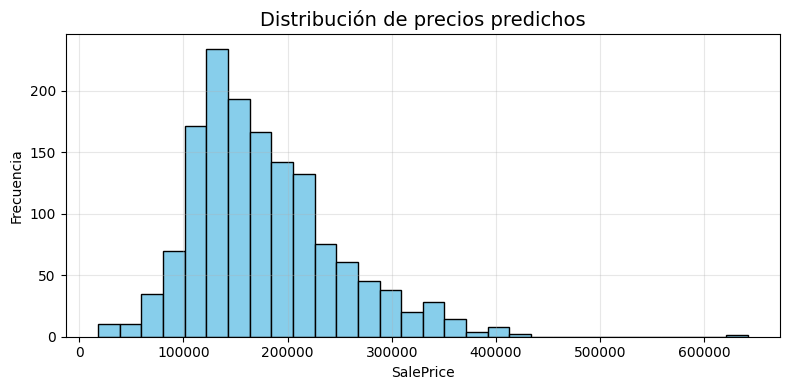

In [ ]:


from sklearn.exceptions import NotFittedError
from sklearn.impute import SimpleImputer


test_proc = test.copy()

try:
    _ = pipeline.named_steps['select']
except (AttributeError, NotFittedError):
    raise RuntimeError("⚠️ El pipeline no ha sido entrenado. Ejecuta las celdas de entrenamiento antes de esta.")


for col in features:
    if col not in test_proc.columns:
        print(f"⚠️ Columna faltante en test: {col} — será creada con NaN")
        test_proc[col] = np.nan


for c in categorical_features:
    if c not in test_proc.columns:
        print(f"⚠️ Columna categórica faltante en test: {c} — será creada con 'Missing'")
        test_proc[c] = 'Missing'


test_X = test_proc[features].copy()

print(f"✅ Conjunto de prueba listo: {test_X.shape[0]} filas, {test_X.shape[1]} columnas")


num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Separar los tipos
num_cols = [c for c in test_X.columns if c in numeric_features]
cat_cols = [c for c in test_X.columns if c in categorical_features]

# Aplicar imputadores
if len(num_cols) > 0:
    test_X[num_cols] = num_imputer.fit_transform(test_X[num_cols])
if len(cat_cols) > 0:
    test_X[cat_cols] = cat_imputer.fit_transform(test_X[cat_cols])

print("✅ Imputación de valores faltantes completada correctamente")


X_test_processed = pipeline.transform(test_X)

print("✅ Transformación del test completada correctamente")
print('Forma final del test procesado:', X_test_processed.shape)


preds = model.predict(X_test_processed)


if 'Id' in test.columns:
    submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': preds})
else:
    submission = pd.DataFrame({'SalePrice': preds})


submission.to_csv('predicciones.csv', index=False)
print("✅ Archivo 'predicciones.csv' guardado con éxito en predicciones.csv")


display(submission.head(10))
print("\n📊 Estadísticas básicas de predicciones:")
display(submission['SalePrice'].describe())


plt.figure(figsize=(8,4))
plt.hist(submission['SalePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de precios predichos', fontsize=14)
plt.xlabel('SalePrice')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


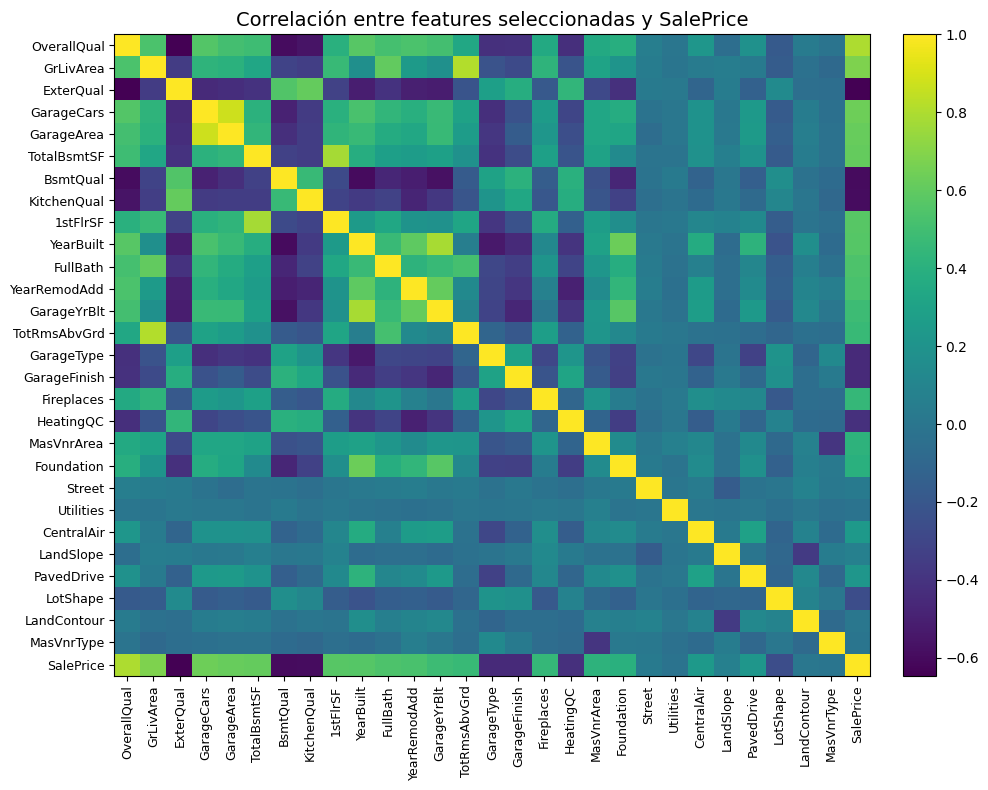


Correlación con SalePrice (ordenada):


SalePrice       1.000000
OverallQual     0.794662
GrLivArea       0.679771
GarageCars      0.634851
GarageArea      0.616779
TotalBsmtSF     0.613149
1stFlrSF        0.575542
YearBuilt       0.563124
FullBath        0.538079
YearRemodAdd    0.527127
GarageYrBlt     0.483859
TotRmsAbvGrd    0.460851
Fireplaces      0.451418
MasVnrArea      0.415098
Foundation      0.398662
CentralAir      0.238030
PavedDrive      0.220783
LandSlope       0.073443
Street          0.029723
LandContour     0.007311
MasVnrType     -0.004269
Utilities      -0.016348
LotShape       -0.259175
HeatingQC      -0.418443
GarageFinish   -0.451530
GarageType     -0.452703
KitchenQual    -0.592295
BsmtQual       -0.596133
ExterQual      -0.644857
Name: SalePrice, dtype: float64

In [25]:

# Heatmap de correlación entre las features seleccionadas y SalePrice (si SalePrice estaba en df)
sel_df = working[features + ['SalePrice']].copy()
for col in sel_df.columns:
    if sel_df[col].dtype == 'object' or str(sel_df[col].dtype).startswith('category'):
        sel_df[col] = sel_df[col].astype('category').cat.codes
sel_df = sel_df.dropna()

corr_sel = sel_df.corr()

plt.figure(figsize=(10,8))
im = plt.imshow(corr_sel, aspect='auto', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Correlación entre features seleccionadas y SalePrice', fontsize=14)
cols = corr_sel.columns.tolist()
plt.xticks(range(len(cols)), cols, rotation=90, fontsize=9)
plt.yticks(range(len(cols)), cols, fontsize=9)
plt.tight_layout()
plt.show()

# Mostrar correlación con SalePrice ordenada
if 'SalePrice' in corr_sel.columns:
    corr_with_target = corr_sel['SalePrice'].sort_values(ascending=False)
    print('\nCorrelación con SalePrice (ordenada):')
    display(corr_with_target)
